In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
# Joachim DAVID december 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
pd.set_option('display.max_columns', None)

#%cd D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\original_data

print(sys.path[0])
#import matplotlib
#matplotlib.matplotlib_fname()

filepath = 'original_data'
file_used = 'productionfile.csv'

time_period = 1800 #seconds

In [50]:
sys.path[0]

''

In [51]:
filename = os.path.join(filepath, file_used)
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
all_reasons = list(df.ReasonId.unique())
all_reasons.sort()
print(all_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


In [52]:
# VARIABLES
# cutoff_perc = 100
# dtcutoff_perc = 100
# reasons_relative = [1, 3, 5, 7, 8]
# reasons_absolute = [9, 10, 11]
# reasons_not_considered = [2]
# group = True
choice='PastaType'

In [53]:
def add_column_type(df, from_col='ArticleName', choice='BigPack'):
    choices = ['BigPack', 'Marque', 'PastaType']
    newname = choice

    if newname == choices[0]:
        stringlist = [' 8', ' 10', ' 12', ' 16', ' 18' ,' 20']
    elif newname == choices[1]:
        stringlist = ['DLL 365', 'VALUE', 'AMBRA', 'EVERYDAY', 'WINNY', 'CARREFOUR', 'ALDI', 'ECO+', 'TOSCA', 'CASA ITALIANA',
                     'EUROSHOPPER', 'AH', 'PASTA MARE', 'OKE', 'TOP BUDGET', 'FIORINI', 'BIO VILLAGE', 'MONOPP', 'RINATURA',
                     'JUMBO', 'BONI', 'CASINO', 'TURINI']
    elif newname == choices[2]:
        stringlist = [['MACARONI', 'MAC.'], 'FUSILLI', ['SPIRELLI', 'SPIRAL', 'TORSADES'], 
                      ['VERMICELLI', 'VERMICELL'], ['NOODLES', 'NOUILLES'], 'TORTI', 'HORENTJE',
                     ['PENNE', 'PIPE'], ['ELLEBOOGJES', 'COQUILLETTE', 'COQ.'], 'ZITTI', 'HELICES', 'MIE']
    else:
        raise NameError("The choice '{}' is not defined".format(newname))
    
    # Generate a new column with categories in the dataframe
    bp = np.full(df.shape[0], 'Other')
    name = df[from_col]
    for s in stringlist:
        if type(s) == list:
            new_s = ('|'.join(s))
            bp = np.where(name.str.contains(new_s), s[0], bp)
        else:
            if newname == 'BigPack':
                bp = np.where(name.str.contains(s), s + 'X', bp)
            else:
                bp = np.where(name.str.contains(s), s, bp)
    df[newname] = bp
    return df
df = add_column_type(df, choice=choice)

In [54]:
df

,EquipmentId,ProductionRequestId,SegmentResponseId,StartDateUTC,EndDateUTC,Duration,ReasonId,IgnoreType,ArticleCode,ArticleName,Type,PastaType
0,50,50675.0,74525.0,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64.000,10,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI
1,50,50675.0,74525.0,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860.000,1,NaN,FF029001,MACARONI KORT PLATTE ZAK,RunTime,MACARONI
2,50,50675.0,74525.0,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414.000,8,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI
3,50,50675.0,74525.0,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871.000,1,NaN,FF029001,MACARONI KORT PLATTE ZAK,RunTime,MACARONI
4,50,50675.0,74525.0,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177.000,10,NaN,FF029001,MACARONI KORT PLATTE ZAK,DownTime,MACARONI
5,50,50675.0,74525.0,2016-01-19 19:44:53.073,2016-01-19 19:49:18.047,265.000,1,NaN,FF029001,MACARONI KORT PLATTE ZAK,RunTime,MACARONI
6,0,0.0,0.0,2016-01-19 19:49:18.047,2016-01-21 09:56:44.780,137246.733,0,NaN,000000EU,NONE,Break,Other
7,50,50724.0,74711.0,2016-01-21 09:56:44.780,2016-01-21 09:58:50.930,126.000,9,NaN,FF011501,"GESNEDEN MACARONI AS 0,9%",DownTime,MACARONI
8,50,50724.0,74711.0,2016-01-21 09:58:50.930,2016-01-21 10:51:08.090,3138.000,1,NaN,FF011501,"GESNEDEN MACARONI AS 0,9%",RunTime,MACARONI
9,50,50724.0,74711.0,2016-01-21 10:51:08.090,2016-01-21 10:56:02.120,294.000,8,NaN,FF011501,"GESNEDEN MACARONI AS 0,9%",DownTime,MACARONI


### Export for simulator file and visualise

In [55]:
def add_breaks(production):
    add_df = pd.DataFrame([], columns = production.columns)
    prid = -1
    maxtime = 7200
    for firstnumber, secondnumber in zip(production[:-1].T, production[1:].T):
        oldenddate = production.loc[firstnumber, 'EndDateUTC']
        newstartdate = production.loc[secondnumber, 'StartDateUTC']
        diff = (newstartdate - oldenddate).total_seconds()
        oldprid = production.loc[firstnumber, 'ProductionRequestId']
        newprid = production.loc[secondnumber, 'ProductionRequestId']
        while diff > 0:
            if diff > maxtime:
                new_row = pd.Series({'ProductionRequestId': int(prid),
                                     'StartDateUTC': oldenddate,
                                     'EndDateUTC': oldenddate + pd.Timedelta(maxtime, 's'),
                                     'Duration': maxtime,
                                     'ReasonId': 0,
                                     'ArticleName': 'NONE'})
                diff -= maxtime
                oldenddate = oldenddate + pd.Timedelta(maxtime, 's')
            else: # diff <= maxtime
                new_row = pd.Series({'ProductionRequestId': int(prid),
                     'StartDateUTC': oldenddate,
                     'EndDateUTC': newstartdate,
                     'Duration': diff,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
                diff -= diff
            #oldprid = production.loc[firstnumber, 'ProductionRequestId']
            #newprid = production.loc[secondnumber, 'ProductionRequestId']
            #if oldprid != newprid:
            #    print('Not the same!')
            #    #print(firstnumber, diff, newstartdate)
            prid -= 1
#             else:
#                 new_row = pd.Series({'ProductionRequestId': oldprid,
#                                      'StartDateUTC': oldenddate,
#                                      'EndDateUTC': newstartdate,
#                                      'Duration': diff,
#                                      'ReasonId': 0,
#                                      'ArticleName': production.loc[firstnumber, 'ArticleName']})
            
            add_df = add_df.append(new_row, ignore_index=True)
        else:
            pass
    production = production.append(add_df, ignore_index=True)
    production = production.sort_values('StartDateUTC').reset_index(drop=True)
    return production

In [60]:
df_task = df.copy()
df_task['ReasonId'] = np.where(df_task.Type == 'RunTime', 100, df_task.ReasonId)
df_task = df_task[['ProductionRequestId', 'StartDateUTC' , 'EndDateUTC', 'Duration', 'ReasonId', 'ArticleName']]
#df_task = df_task[df_task['StartDateUTC'] < df_task['StartDateUTC'][0] + pd.to_timedelta('14days')]
df_task = df_task[df_task.ProductionRequestId != 0]
df_task = df_task[df_task.ProductionRequestId.isin(df.ProductionRequestId.unique()[10:40])]
df_task = add_breaks(df_task)
df_task.head()

,ProductionRequestId,StartDateUTC,EndDateUTC,Duration,ReasonId,ArticleName
0,50703,2016-01-25 18:16:20.717,2016-01-25 18:18:26.000,126.000,10,"SPIRALEN DURUM AS 1,1%"
1,50703,2016-01-25 18:18:26.000,2016-01-26 01:26:52.847,25706.000,100,"SPIRALEN DURUM AS 1,1%"
2,50703,2016-01-26 01:26:52.847,2016-01-26 01:33:33.140,401.000,10,"SPIRALEN DURUM AS 1,1%"
3,-1,2016-01-26 01:33:33.140,2016-01-26 01:33:37.847,4.707,0,NONE
4,50741,2016-01-26 01:33:37.847,2016-01-26 01:39:45.923,368.000,1,HORENTJE H/Z 10/90


In [61]:
df_task.ProductionRequestId.unique()

array([50703.0, -1, 50741.0, -2, 50912.0, -3, 50913.0, -4, 50877.0, -5,
       50926.0, -6, 50925.0, -7, 51037.0, -8, 51036.0, -9, 51099.0, -10,
       50676.0, -11, -12, -13, -14, 51098.0, -15, -16, -17, -18, -19, -20,
       -21, -22, 51166.0, -23, 50831.0, -24, -25, -26, -27, -28, -29, -30,
       -31, -32, -33, -34, -35, 51216.0, -36, 51215.0, -37, 51209.0, -38,
       51210.0, -39, 51214.0, -40, 51213.0, -41, 51211.0, -42, 51207.0,
       -43, 51212.0, -44, 51262.0, -45, 51304.0, 51306.0, -46, 51298.0,
       -47, 51354.0, -48, 51352.0, -49, -50, -51, 51350.0], dtype=object)

In [62]:
prodtime = df_task.Duration[df_task.ArticleName != 'NONE'].sum() / 3600
print('Production time', prodtime)
idletime = df_task.Duration[df_task.ArticleName == 'NONE'].sum() / 3600
print('Idle time', idletime)

Production time 227.85583333333332
Idle time 54.7598125


In [63]:
def plot_gantt(df_task, reason_str, articlename, startdate='StartDateUTC', enddate='EndDateUTC'):
    df_task['Start'] = (df_task[startdate] - df_task[startdate].iloc[0].floor('D')).dt.total_seconds()/3600
    df_task['End'] = (df_task[enddate] - df_task[startdate].iloc[0].floor('D')).dt.total_seconds()/3600
    # Plot a line for every line of data in your file
    from cycler import cycler
    cy = cycler(color=['b','g','orange','c','m','yellow','steelblue', 'tan',
                                              'lawngreen', 'cyan', 'darkorange', 'crimson', 'greenyellow', 'darkviolet', 'fuchsia',
                                              'palevioletred', 'moccasin',
                                              'rosybrown', 'coral', 'wheat',
                                              'linen']*2).by_key()['color']
    reasons = np.sort(df_task[reason_str].unique())
    #reasons = [0, 9, 10, 11, 20]
    for reason, color in zip(reasons, cy):
        df_temp = df_task[df_task[reason_str] == reason]
        plt.hlines(df_temp[articlename], df_temp['Start'], df_temp['End'], colors=color, lw=4, label=reason)
    #plt.hlines(cps, s_process, f_process, colors="green", lw=4)
    #plt.hlines(cps, s_unload, f_unload, color="blue", lw=4)
    plt.margins(0.1)
    plt.legend()
    plt.xlabel('Time[h]')
    timerange = np.arange(0, np.max(df_temp['End'])+24, 24)
    label = pd.date_range(df_task[startdate].iloc[0].floor('D'), periods = len(timerange))
    plt.xticks(timerange, label, rotation=90)
    plt.xlim(timerange.min(), timerange.max())
    return label

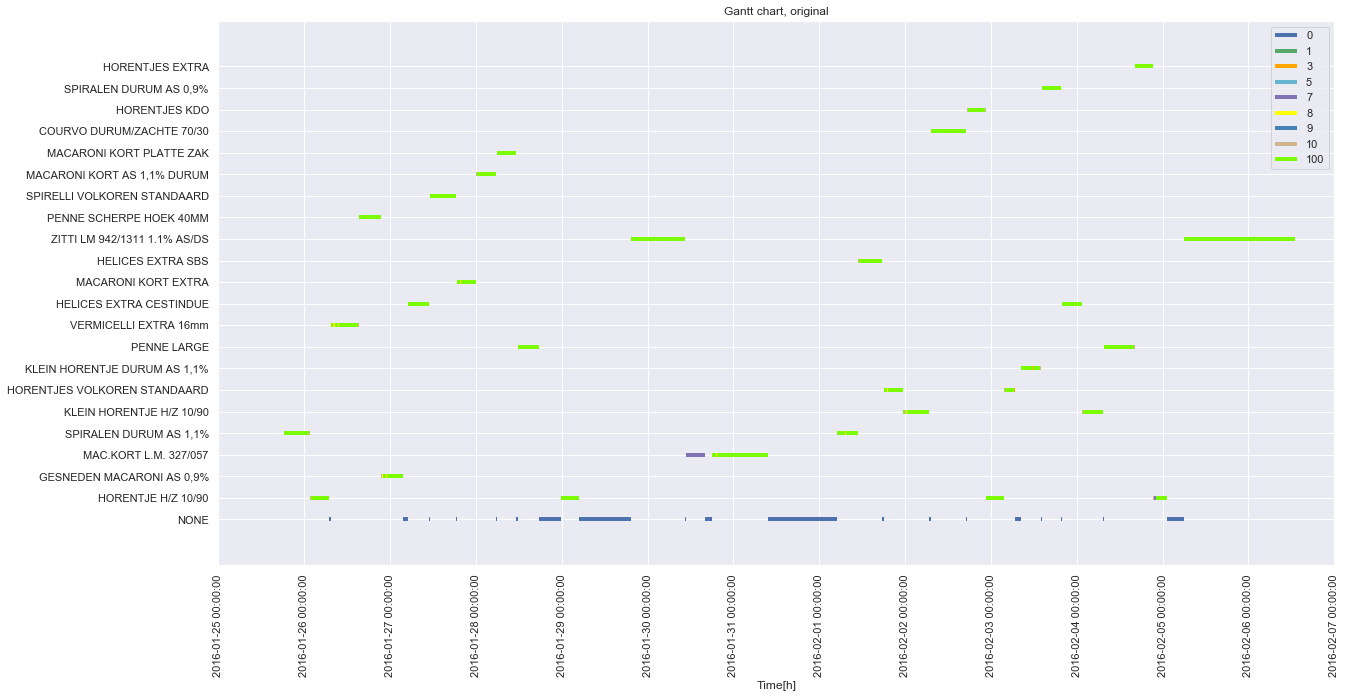

In [64]:
plt.figure(figsize=(20, 10))
# df_task['Start'] = (df_task.StartDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
# df_task['End'] = (df_task.EndDateUTC - df_task.StartDateUTC[0].floor('D')).dt.total_seconds()/3600
plot_gantt(df_task, 'ReasonId', 'ArticleName')
plt.title('Gantt chart, original')
plt.savefig('D:/temp/gantt.png', dpi=300, bbox_inches='tight')
plt.show()

In [65]:
#import os
#os.chdir(r'D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Revised')

In [66]:
def group_productions(df_task):
    group = df_task.groupby('ProductionRequestId').agg({'StartDateUTC':'min', 'EndDateUTC':'max', 'ArticleName':'first'}).sort_values(by='StartDateUTC')
    group_uptime = df_task[df_task.ReasonId == 100].groupby('ProductionRequestId').agg({'Duration':'sum'}) / 60 / 60
    group_alltime = df_task.groupby('ProductionRequestId').agg({'Duration':'sum'}) / 60 / 60
    group = pd.concat([group_alltime, group], axis=1)
    group = group.sort_values(by='StartDateUTC')
    group.Duration = group.Duration
    group.index = group.index.astype(int)
    return group

def simplify_productions(group, num_minutes):
    df = group.copy()
    df['Duration'] = df['Duration']*60
    #df['Duration'] = df['Duration'].apply(np.round).astype(int)
    df['Duration'] = (df['Duration'] // num_minutes) * num_minutes
    i = 0
    for j, k in zip(df.iloc[:-1].T, df.iloc[1:].T):
        if i == 0:
            df.loc[j, 'StartDateUTC'] = df.loc[j, 'StartDateUTC'].round(str(num_minutes) + 'min')
            df.loc[j, 'EndDateUTC'] = df.loc[j, 'StartDateUTC'] + pd.Timedelta(minutes = df.loc[j, 'Duration'])
            i += 1
        df.loc[k, 'StartDateUTC'] = df.loc[j, 'EndDateUTC']
        df.loc[k, 'EndDateUTC'] = df.loc[k, 'StartDateUTC'] + pd.Timedelta(minutes = df.loc[k, 'Duration'])
    df = df[df['Duration'] > 0]
    df['Duration'] = df['Duration']/60
    return df

def save_durations(group, output):
    out = group.copy()
    out.columns = ['Duration', 'Start', 'End', 'Product']
    for col in ['Start', 'End']:
        out[col] = out[col].dt.strftime("%Y-%m-%d %H:%M:%S.%f")
    out.insert(3, 'Quantity', 20)
    out = add_column_type(out , 'Product', 'PastaType')
    out.columns.values[-1] = 'Type'
    out.index.name = 'ID'
    out.to_csv(output)

group = group_productions(df_task)
group = simplify_productions(group, 10)

In [67]:
group.head()

,Duration,StartDateUTC,EndDateUTC,ArticleName
ProductionRequestId,,,,
50703,7.166667,2016-01-25 18:20:00,2016-01-26 01:30:00,"SPIRALEN DURUM AS 1,1%"
50741,5.333333,2016-01-26 01:30:00,2016-01-26 06:50:00,HORENTJE H/Z 10/90
-2,0.333333,2016-01-26 06:50:00,2016-01-26 07:10:00,NONE
50912,7.833333,2016-01-26 07:10:00,2016-01-26 15:00:00,VERMICELLI EXTRA 16mm
-3,0.166667,2016-01-26 15:00:00,2016-01-26 15:10:00,NONE


In [69]:
save_durations(group, os.path.join(filepath,'generated_jobInfoProd.csv'))
reasonlist = np.where(np.array(group['ArticleName']) == 'NONE', 0, 100) 
group['ReasonId'] = reasonlist

In [70]:
def energy_per_production(group):
    articlenum = len(group.ArticleName.unique())
    rand = np.random.random_sample((articlenum,)) * 0.2 + 0.1
    energycons = pd.concat([pd.Series(group.ArticleName.unique()), pd.Series(rand)], axis=1)
    energycons.columns = ['Product', 'Power']
    energycons.insert(1, 'UnitPrice', 5)
    energycons.insert(len(energycons.columns), 'TargetProductionRate', 3000)
    energycons.loc[energycons.Product == 'NONE', 'Power'] = 0
    return energycons

energycons = energy_per_production(group)
# energycons = add_column_type(energycons, 'Product', 'PastaType')
# energycons.columns.values[-1] = 'Type'
energycons.to_csv(os.path.join(filepath, 'generated_productRelatedCharacteristics.csv'), index=False)

In [71]:
energycons.head()

,Product,UnitPrice,Power,TargetProductionRate
0,"SPIRALEN DURUM AS 1,1%",5,0.290709,3000
1,HORENTJE H/Z 10/90,5,0.284939,3000
2,NONE,5,0.000000,3000
3,VERMICELLI EXTRA 16mm,5,0.240008,3000
4,PENNE SCHERPE HOEK 40MM,5,0.191153,3000


In [72]:
startdate = group.StartDateUTC.min()
firstofmonth = (startdate - pd.offsets.MonthBegin(1)).floor('D')
enddate = group.StartDateUTC.max()
lastofmonth = (enddate + pd.offsets.MonthEnd(1)).ceil('D')
lastofmonth

def construct_energy_2tarifs(ran, daytarif, nighttarif, starttime, endtime):
    ind = pd.date_range(freq='H', start=ran[0], end=ran[1])
    prices = pd.DataFrame([daytarif] * len(ind), index=ind)

    night = (ind.weekday >= 5) | (ind.hour < endtime) | (ind.hour >= starttime) # saturday or sunday, after 21 and before 6
    prices[night] = nighttarif
    prices.columns = ['Euro']
    prices.index.name = 'Date'
    #prices = prices.loc[prices['Euro'].diff(1) != 0]
    return prices

prices = construct_energy_2tarifs((firstofmonth, lastofmonth), 12, 8, 21, 6)
prices.to_csv(os.path.join(filepath, 'generated_hourly_energy_price.csv'))
prices.head()

,Euro
Date,
2016-01-01 00:00:00,8
2016-01-01 01:00:00,8
2016-01-01 02:00:00,8
2016-01-01 03:00:00,8
2016-01-01 04:00:00,8


In [73]:
def calculate_energy_cost(df_tasks, df_cost, df_cons, return_table=False):
    lastenddate = df_tasks.iloc[-1]['EndDateUTC']
    new_row = pd.Series({'ProductionRequestId': -1000,
                     'StartDateUTC': lastenddate,
                     'EndDateUTC': lastenddate + pd.Timedelta(1, 's'),
                     'Duration': 1,
                     'ReasonId': 0,
                     'ArticleName': 'NONE'})
    df_tasks = df_tasks.append(new_row, ignore_index=True)
    #print(df_tasks)
    
    # Set timedateindex
    df_tasks = df_tasks.merge(df_cons, how='left', left_on='ArticleName', right_on='Product').set_index('StartDateUTC', drop=True)
    
    # Concatenate the list of tasks and the energy cost on axis 0
    out_table = pd.concat([df_tasks, df_cost]).sort_index()
    out_table = out_table[df_tasks.index[0]: df_tasks.index[-1]]
    
    
    # Determine the length of each time interval
    # Make a new index with all changes and their length in hours
    alldates = out_table.index
    times = -pd.Series(((alldates - pd.Timestamp("1970-01-01")) / pd.Timedelta('1s'))).diff(-1)
    out_table = out_table.reset_index(drop=True)
    out_table['Difftime'] = times
    out_table.index = alldates
    out_table = out_table.iloc[:-1]
    out_table = out_table[['Product', 'Difftime', 'Euro', 'Power']].ffill().bfill()

    out_table = out_table[out_table.Difftime > 0]
    
    out_table['Price'] = (out_table['Difftime'] * out_table['Euro'] * out_table['Power']) / 3600
    total_sum = out_table['Price'].sum()
    
    if return_table:
        return total_sum, out_table
    else:
        return total_sum

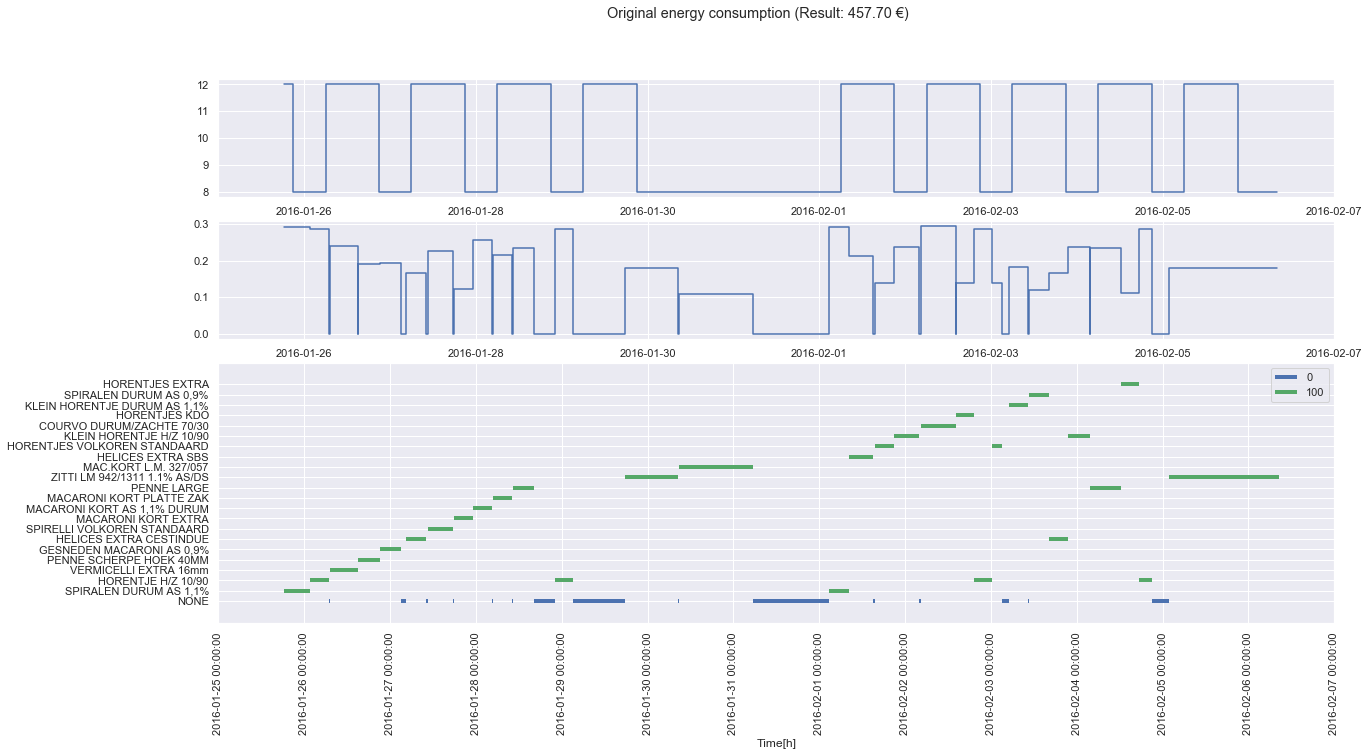

In [74]:
plt.figure(figsize=(20, 10))
c, table = calculate_energy_cost(group, prices, energycons, True)

plt.subplot(4,1,(3,4))
timerange = plot_gantt(group, 'ReasonId', 'ArticleName')

plt.subplot(4,1,1)
plt.suptitle('Original energy consumption (Result: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(4,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')
plt.show()

In [75]:
def reorder_schedule(id_list, schedule):
    startdate = schedule.iloc[0]['StartDateUTC']
    df = schedule.loc[id_list]
    #print(df)
    for row in df.T:
        #print(df.loc[row])
        df.loc[row, 'StartDateUTC'] = startdate
        enddate = startdate + pd.Timedelta(df.loc[row, 'Duration'], unit='h')
        df.loc[row, 'EndDateUTC'] = enddate
        #print(df.loc[row])
        startdate = enddate
    return df

In [76]:
start_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).min())
end_time = pd.Timestamp(np.array(group.loc[:, ['StartDateUTC', 'EndDateUTC']]).max())
start_time, end_time

(Timestamp('2016-01-25 18:20:00'), Timestamp('2016-02-06 08:40:00'))

In [83]:
from SchedulerV000 import run_opt
files = [os.path.join(filepath, f) for f in ['generated_productRelatedCharacteristics.csv', 'generated_hourly_energy_price.csv', 'generated_jobInfoProd.csv']]
cand_sched, best_result_list, worst_result_list, result_dict_origin, result_dict = run_opt(start_time, end_time, 
       [], [],
        *files, 
        1, 2000, 0.4, 0.4, 12, num_mutations=4)

Unexpected error when reading down duration information from '[]'


D:\users\jdavid\Programming\GitHub\SchedulingSimulator\ELITEPython\Deliverable\SchedulerV000.py:968: UserWarning: Import of downtime durations failed, using scheduling without failure information.
  warnings.warn('Import of downtime durations failed, using scheduling without failure information.')


2000/2000:	420.10562221395637
Candidate schedule [51354   -40 51350   -12   -33   -35   -39   -32   -26 51207 50877 50926
   -21   -28   -43   -13   -34    -6 51037 51215   -46    -5    -7 50831
 51214 51216 50676 51352   -22 51304   -44 50703 51211 51166   -11   -30
   -19    -2 51210 51036   -27 51209   -20   -16 50741 51098 51213   -49
   -17   -15 51262 51212 51099 51306    -3   -29   -51   -50   -18 51298
    -9   -37   -10   -31   -24 50913   -23 50912 50925]
Candidate failure cost: 0
Candidate energy cost: 420.1056222139563
Candidate conversion cost: 0
Candidate total cost: 420.1056222139563

Original schedule: [50703, 50741, -2, 50912, -3, 50913, 50877, -5, 50926, -6, 50925, -7, 51037, 51036, -9, 51099, -10, 50676, -11, -12, -13, 51098, -15, -16, -17, -18, -19, -20, -21, -22, 51166, -23, 50831, -24, -26, -27, -28, -29, -30, -31, -32, -33, -34, -35, 51216, 51215, -37, 51209, 51210, -39, 51214, -40, 51213, 51211, 51207, -43, 51212, -44, 51262, 51304, 51306, -46, 51298, 51354, 513

In [84]:
group_opt = reorder_schedule(cand_sched, group)
reasonlist = np.where(np.array(group_opt['ArticleName']) == 'NONE', 0, 100) 
group_opt['ReasonId'] = reasonlist
group_opt.head()

,Duration,StartDateUTC,EndDateUTC,ArticleName,ReasonId,Start,End
ProductionRequestId,,,,,,,
51354,5.000000,2016-01-25 18:20:00.000000,2016-01-25 23:20:00.000000,HORENTJES EXTRA,100,252.333333,257.333333
-40,0.166667,2016-01-25 23:20:00.000000,2016-01-25 23:30:00.001200,NONE,0,206.166667,206.333333
51350,30.833333,2016-01-25 23:30:00.001200,2016-01-27 06:20:00.000000,ZITTI LM 942/1311 1.1% AS/DS,100,265.833333,296.666667
-12,2.000000,2016-01-27 06:20:00.000000,2016-01-27 08:20:00.000000,NONE,0,90.166667,92.166667
-33,2.000000,2016-01-27 08:20:00.000000,2016-01-27 10:20:00.000000,NONE,0,165.500000,167.500000


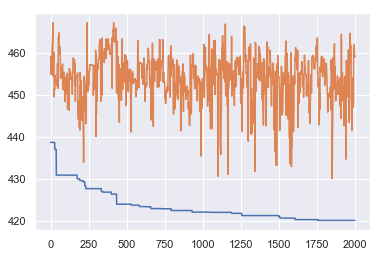

In [85]:
plt.plot(best_result_list)
plt.plot(worst_result_list)

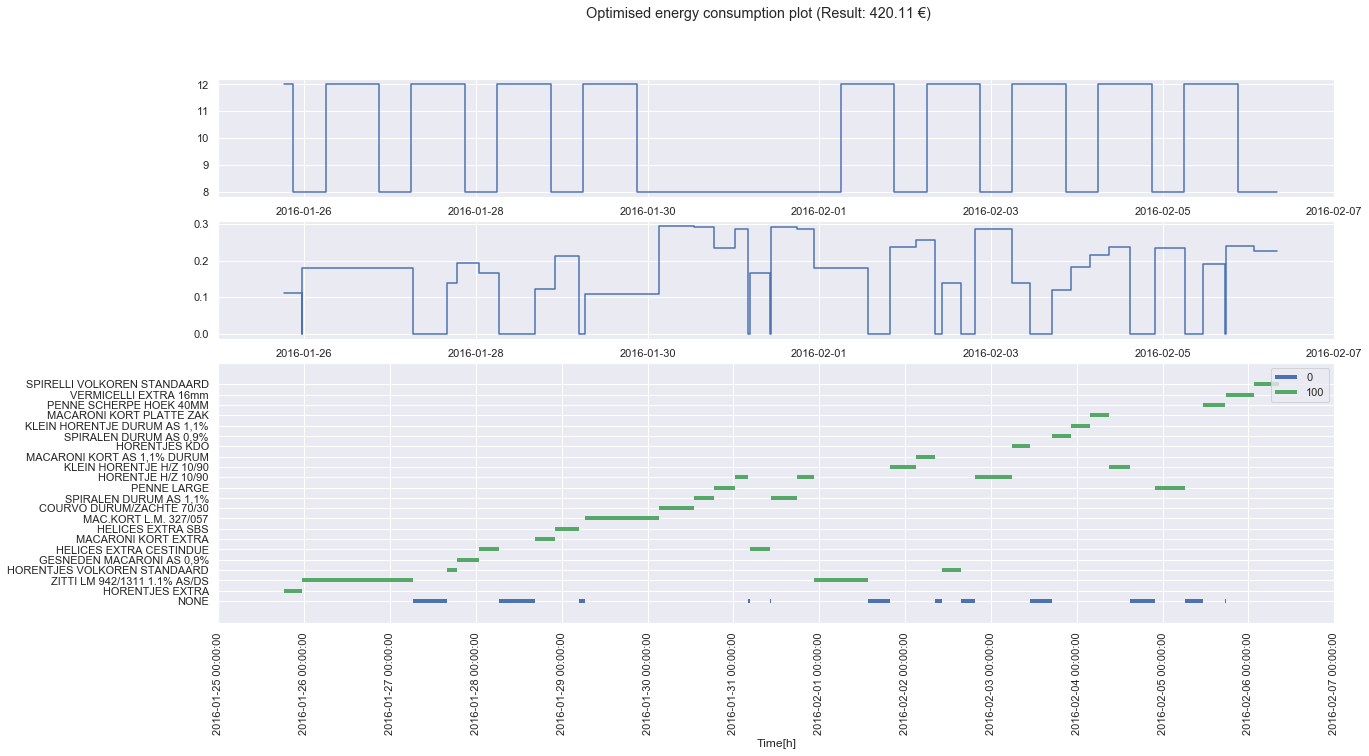

In [86]:
plt.figure(figsize=(20, 10))
c, table = calculate_energy_cost(group_opt, prices, energycons, True)

plt.subplot(4,1,(3,4))
timerange = plot_gantt(group_opt, 'ReasonId', 'ArticleName')

plt.subplot(4,1,1)
plt.suptitle('Optimised energy consumption plot (Result: {:.2f} €)'.format(c))
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Euro, drawstyle='steps-post')

plt.subplot(4,1,2)
plt.xlim(timerange[0], timerange[-1])
plt.plot(table.Power, drawstyle='steps-post')

In [29]:
# df_task = df[['StartDateUTC', 'EndDateUTC', 'ArticleName', 'Type']]
# df_task.columns = ['Start', 'Finish', 'Task', 'Resource']
# df_task = df_task.iloc[1:2000]
# df_task = df_task.reset_index(drop=True)
# df_task.head()

In [30]:
# df_task.Resource.unique()

In [31]:
# import plotly.plotly as py
# import plotly.figure_factory as ff
# # colors = {'DownTime': 'rgb(220, 0, 0)',
# #           'RunTime': 'rgb(0, 255, 100)',
# #          'Break': 'rgb(255, 230, 25)'}
# fig = ff.create_gantt(df_task, group_tasks=True, show_colorbar=True)
# py.iplot(fig, world_readable=True)

In [32]:
#     df_temp = df[]
#     from probdist import duration_between_downtime
#     bool_up = (df.Type == 'RunTime') # List of all RunTimes
#     bool_down = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
#     # Will ignore types of DownTimes not in the list
#     duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600 # hours